# Este Notebook solo funciona en colab

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

from google.colab import drive
from google.colab import files

import os
import shutil

from datetime import datetime

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/ProcesedData'
BASE_PATH = 'dataset'

In [ ]:
splits = os.listdir(DRIVE_PATH)
print(splits)
letters = sorted(os.listdir(os.path.join(DRIVE_PATH,splits[0])))
for letter in letters:
  print(f'--------- {letter} --------')
  for split in splits:
    amount = len(os.listdir(os.path.join(DRIVE_PATH, split,letter)))
    print(f'{letter} has {amount} images for {split}.')

['train', 'validation', 'test']
--------- A --------
A has 1852 images for train.
A has 370 images for validation.
A has 248 images for test.
--------- B --------
B has 1852 images for train.
B has 370 images for validation.
B has 248 images for test.
--------- C --------
C has 1852 images for train.
C has 370 images for validation.
C has 248 images for test.
--------- D --------
D has 1852 images for train.
D has 370 images for validation.
D has 248 images for test.
--------- E --------
E has 1852 images for train.
E has 370 images for validation.
E has 248 images for test.
--------- F --------
F has 1852 images for train.
F has 370 images for validation.
F has 248 images for test.
--------- G --------
G has 1852 images for train.
G has 370 images for validation.
G has 248 images for test.
--------- H --------
H has 1852 images for train.
H has 370 images for validation.
H has 248 images for test.
--------- I --------
I has 1852 images for train.
I has 370 images for validation.
I has

In [ ]:
t0 = datetime.now()

if not os.path.exists(BASE_PATH):
  # os.mkdir(BASE_PATH)
  shutil.copytree(DRIVE_PATH,BASE_PATH)
  print('Data copied in',datetime.now()-t0)
else:
  print('El dataset ya existia')

Data copied in 0:26:28.630507


In [ ]:
categories = os.listdir(BASE_PATH)
letters = sorted(os.listdir(os.path.join(BASE_PATH,categories[0])))
df = np.zeros((len(categories)*len(letters),3))
df = pd.DataFrame(df, columns=['Category','Letter','Count'])
# print(df[(0+1)*2])
row = 0
for i, category in enumerate(categories):
  for letter in letters:
    df.iloc[row,0] = category
    df.iloc[row,1] = letter
    df.iloc[row,2] = len(os.listdir(os.path.join(BASE_PATH,category, letter)))
    row+=1

<ipython-input-5-f6592560f1a9>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'validation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[row,0] = category
<ipython-input-5-f6592560f1a9>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[row,1] = letter


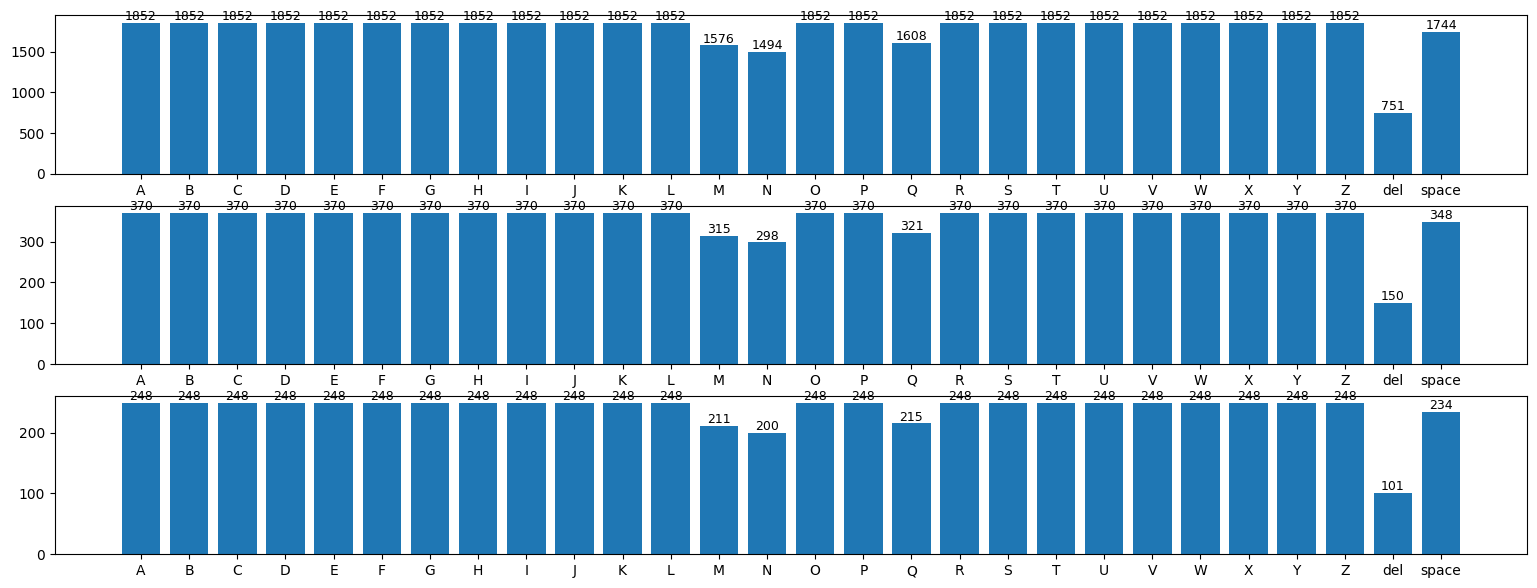

In [ ]:
plt.figure(figsize=(19,7))
# plt.subplots(3)
for i,category in enumerate(['train','validation','test']):
  plt.subplot(3,1,i+1)
  bars = plt.bar(letters, df[df['Category']==category]['Count'])
  for bar in bars:
      height = int(bar.get_height())
      plt.text(bar.get_x() + bar.get_width()/2, height, str(height),
             ha='center', va='bottom', fontsize=9)
plt.show()

In [ ]:
train_dir = os.path.join(BASE_PATH, 'train')
validation_dir = os.path.join(BASE_PATH, 'validation')
test_dir = os.path.join(BASE_PATH, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size =64,
    target_size=(300,300),
    class_mode= 'categorical',
    color_mode = 'grayscale',
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    target_size=(300,300),
    class_mode = 'categorical',
    color_mode = 'grayscale',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(300,300),
    class_mode='categorical',  # Asegúrate de que es el mismo class_mode que en train/val
    color_mode='grayscale',
    shuffle=False,  # No mezclar para mantener el orden de los archivos
)

Found 49769 images belonging to 28 classes.
Found 9942 images belonging to 28 classes.
Found 6665 images belonging to 28 classes.


In [ ]:
def evaluate_model(name, model, history):
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=((10,5)))
  plt.plot(range(len(train_acc)),train_acc, 'o')
  plt.plot(range(len(train_acc)),val_acc, '-')
  plt.title('Train - Validation Accuracy')
  plt.legend(['Train','Validation'])
  plt.xticks(range(len(train_acc)))
  plt.grid(axis='x')

  plt.figure(figsize=((10,5)))
  plt.plot(range(len(train_acc)),train_loss, 'o')
  plt.plot(range(len(train_acc)),val_loss, '-')
  plt.title('Train - Validation Loss')
  plt.xticks(range(len(train_acc)))
  plt.legend(['Train','Validation'])
  plt.grid(axis='x')
  plt.show()


  y_pred = model.predict(test_generator)

  predicted_classes = np.argmax(y_pred,axis=1)
  class_labels = test_generator.class_indices.keys()

  cm = confusion_matrix(test_generator.classes, predicted_classes)

  plt.figure(figsize=(10,10))
  sns.heatmap(cm,annot=True, fmt='d',cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('Real')
  plt.title(f'Confusion matrix {name}')
  plt.show()

  test_loss, test_acc = model.evaluate(test_generator)
  print(f"Test Accuracy: {test_acc:.4f}"  )
  print(f"Max val Accuracy: {max(val_acc):.4f}"  )
  print(f"Max train Accuracy: {max(train_acc):.4f}"  )

In [ ]:
def save_model(name, model):
  name = 'ASP_3_'+name+'.keras'
  model.save(name)
  files.download(name)

## Training

## Intento 2

In [ ]:
t0 = datetime.now()
model_9 = Sequential()

model_9.add(layers.Input(shape=(300,300,1)))

model_9.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))

model_9.add(layers.SeparableConv2D(32,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))

model_9.add(layers.SeparableConv2D(64,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))
model_9.add(layers.Dropout(0.3))


model_9.add(layers.SeparableConv2D(128,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))
model_9.add(layers.Dropout(0.3))


model_9.add(layers.SeparableConv2D(256,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))


model_9.add(layers.Flatten())
model_9.add(layers.Dense(512,activation='relu'))
model_9.add(layers.Dropout(0.4))
model_9.add(layers.Dense(28,'softmax'))

model_9.summary()

model_9.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_9_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_9_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 7,
    restore_best_weights = True)

history_9 = model_9.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 40,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks =[early_stop,checkpoint],
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 300, 300, 16)   │            41 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 150, 150, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 75, 75, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 37, 37, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 18, 18, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             

 Total params: 10,679,893 (40.74 MB)

 Trainable params: 10,678,901 (40.74 MB)

 Non-trainable params: 992 (3.88 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4391 - loss: 5.2965
Epoch 1: val_loss improved from inf to 5.00845, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 185s 215ms/step - accuracy: 0.4394 - loss: 5.2921 - val_accuracy: 0.6077 - val_loss: 5.0085
Epoch 2/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8453 - loss: 0.5491
Epoch 2: val_loss improved from 5.00845 to 3.70930, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 132s 144ms/step - accuracy: 0.8453 - loss: 0.5490 - val_accuracy: 0.7539 - val_loss: 3.7093
Epoch 3/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8962 - loss: 0.3889
Epoch 3: val_loss improved from 3.70930 to 3.64378, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.8962 - loss: 0.3888 - val_accuracy: 0.8056 - val_loss: 3.6438
Epoch 4/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9199 - loss: 0.3093
Epoch 4: val_loss improved from 3.64378 to 1.05202, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.9199 - loss: 0.3093 - val_accuracy: 0.9335 - val_loss: 1.0520
Epoch 5/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9375 - loss: 0.2430
Epoch 5: val_loss did not improve from 1.05202
778/778 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accuracy: 0.9375 - loss: 0.2430 - val_accuracy: 0.7898 - val_loss: 2.1722
Epoch 6/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9458 - loss: 0.2229
Epoch 6: val_loss improved from 1.05202 to 0.37846, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 140s 131ms/step - accuracy: 0.9458 - loss: 0.2229 - val_accuracy: 0.9536 - val_loss: 0.3785
Epoch 7/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9558 - loss: 0.1878
Epoch 7: val_loss did not improve from 0.37846
778/778 ━━━━━━━━━━━━━━━━━━━━ 142s 131ms/step - accuracy: 0.9558 - loss: 0.1878 - val_accuracy: 0.7965 - val_loss: 4.9204
Epoch 8/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9597 - loss: 0.1729
Epoch 8: val_loss did not improve from 0.37846
778/778 ━━━━━━━━━━━━━━━━━━━━ 112s 144ms/step - accuracy: 0.9597 - loss: 0.1729 - val_accuracy: 0.8007 - val_loss: 10.2595
Epoch 9/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9607 - loss: 0.1662
Epoch 9: val_loss improved from 0.37846 to 0.21554, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 122s 157ms/step - accuracy: 0.9607 - loss: 0.1662 - val_accuracy: 0.9501 - val_loss: 0.2155
Epoch 10/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9637 - loss: 0.1530
Epoch 10: val_loss did not improve from 0.21554
778/778 ━━━━━━━━━━━━━━━━━━━━ 110s 142ms/step - accuracy: 0.9637 - loss: 0.1530 - val_accuracy: 0.9740 - val_loss: 0.2393
Epoch 11/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9712 - loss: 0.1227
Epoch 11: val_loss did not improve from 0.21554
778/778 ━━━━━━━━━━━━━━━━━━━━ 110s 142ms/step - accuracy: 0.9712 - loss: 0.1228 - val_accuracy: 0.6923 - val_loss: 19.5638
Epoch 12/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9697 - loss: 0.1266
Epoch 12: val_loss improved from 0.21554 to 0.14142, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 117s 150ms/step - accuracy: 0.9697 - loss: 0.1266 - val_accuracy: 0.9787 - val_loss: 0.1414
Epoch 13/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9740 - loss: 0.1144
Epoch 13: val_loss did not improve from 0.14142
778/778 ━━━━━━━━━━━━━━━━━━━━ 137s 143ms/step - accuracy: 0.9740 - loss: 0.1144 - val_accuracy: 0.9319 - val_loss: 0.2525
Epoch 14/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9733 - loss: 0.1186
Epoch 14: val_loss did not improve from 0.14142
778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 147ms/step - accuracy: 0.9733 - loss: 0.1186 - val_accuracy: 0.9789 - val_loss: 0.1698
Epoch 15/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9730 - loss: 0.1181
Epoch 15: val_loss did not improve from 0.14142
778/778 ━━━━━━━━━━━━━━━━━━━━ 109s 140ms/step - accuracy: 0.9730 - loss: 0.1181 - val_accuracy: 0.7607 - val_loss: 0.8698
Epoch 16/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9766 - loss: 0.1016
Epoch 16: val_lo

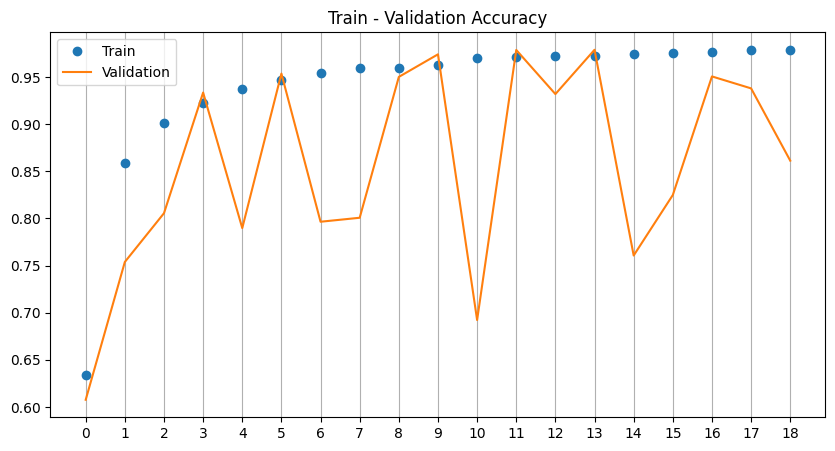

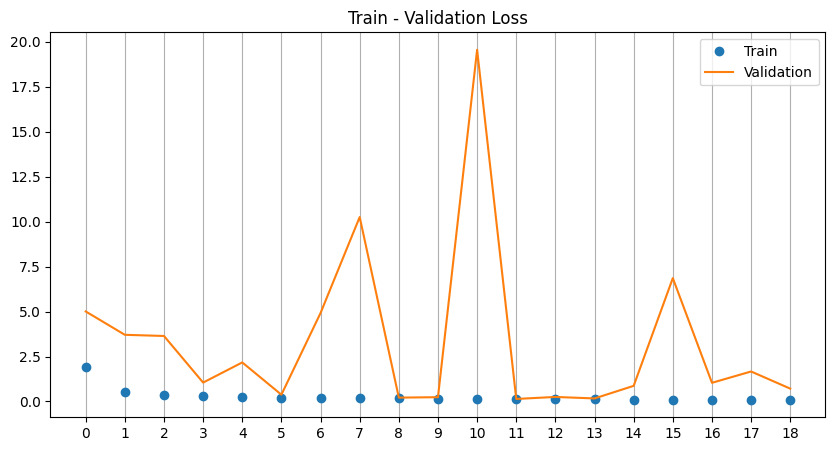

105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step


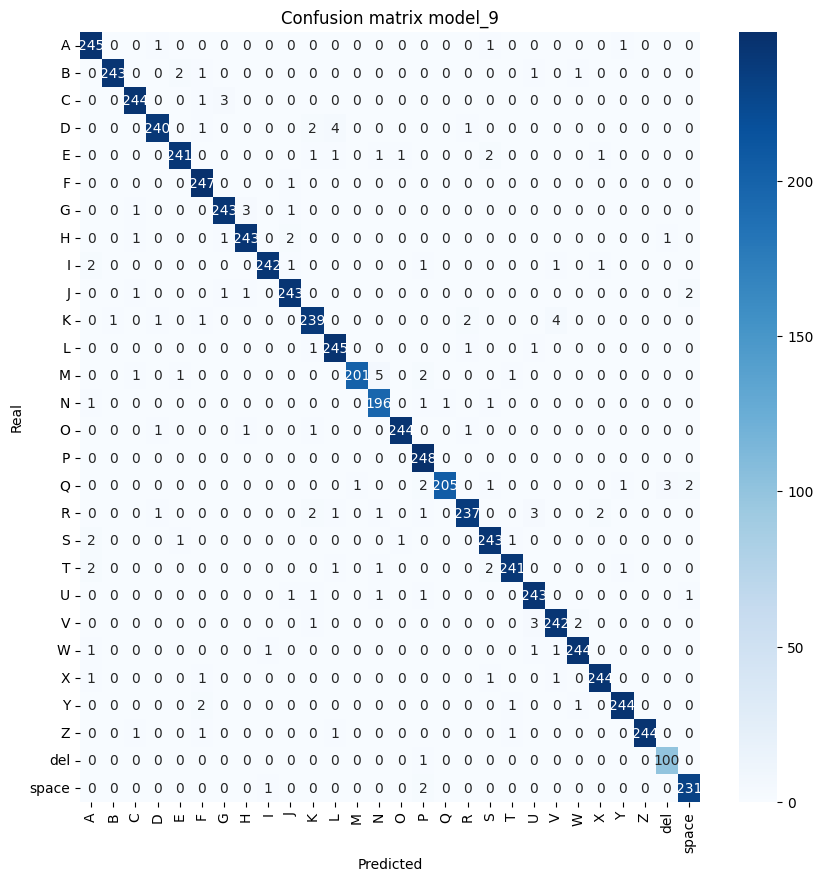

105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9785 - loss: 0.1529
Test Accuracy: 0.9782
Max val Accuracy: 0.9789
Max train Accuracy: 0.9786


In [ ]:
evaluate_model('model_9',model_9,history_9)

In [ ]:
save_model('model_9',model_9)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##intento 3

In [ ]:
t0 = datetime.now()
model_10 = Sequential()

model_10.add(layers.Input(shape=(300,300,3)))

model_10.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))

model_10.add(layers.SeparableConv2D(32,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))
model_10.add(layers.Dropout(0.3))

model_10.add(layers.SeparableConv2D(64,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))


model_10.add(layers.SeparableConv2D(128,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))
model_10.add(layers.Dropout(0.4))


model_10.add(layers.SeparableConv2D(256,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))
model_10.add(layers.Dropout(0.4))


model_10.add(layers.Flatten())
model_10.add(layers.Dense(512,activation='relu'))
model_10.add(layers.Dropout(0.4))
model_10.add(layers.Dense(28,'softmax'))

model_10.summary()

model_10.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_10_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_10_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 4,
    restore_best_weights = True)

history_10 = model_10.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 25,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks =[early_stop,checkpoint],
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 300, 300, 16)   │            91 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 150, 150, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 75, 75, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 37, 37, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 18, 18, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,617,34

 Total params: 10,679,943 (40.74 MB)

 Trainable params: 10,678,951 (40.74 MB)

 Non-trainable params: 992 (3.88 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3646 - loss: 3.9314
Epoch 1: val_loss improved from inf to 0.91240, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 197s 229ms/step - accuracy: 0.3648 - loss: 3.9288 - val_accuracy: 0.7471 - val_loss: 0.9124
Epoch 2/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7313 - loss: 0.9319
Epoch 2: val_loss improved from 0.91240 to 0.77099, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 204ms/step - accuracy: 0.7314 - loss: 0.9318 - val_accuracy: 0.7722 - val_loss: 0.7710
Epoch 3/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8113 - loss: 0.6890
Epoch 3: val_loss did not improve from 0.77099
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.8113 - loss: 0.6890 - val_accuracy: 0.7174 - val_loss: 0.9364
Epoch 4/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8599 - loss: 0.5316
Epoch 4: val_loss improved from 0.77099 to 0.32593, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.8599 - loss: 0.5316 - val_accuracy: 0.9056 - val_loss: 0.3259
Epoch 5/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8854 - loss: 0.4427
Epoch 5: val_loss improved from 0.32593 to 0.28675, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.8854 - loss: 0.4427 - val_accuracy: 0.9141 - val_loss: 0.2868
Epoch 6/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9032 - loss: 0.3827
Epoch 6: val_loss improved from 0.28675 to 0.22717, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 204ms/step - accuracy: 0.9032 - loss: 0.3826 - val_accuracy: 0.9336 - val_loss: 0.2272
Epoch 7/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9137 - loss: 0.3441
Epoch 7: val_loss improved from 0.22717 to 0.19551, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 159s 204ms/step - accuracy: 0.9137 - loss: 0.3441 - val_accuracy: 0.9438 - val_loss: 0.1955
Epoch 8/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9269 - loss: 0.2928
Epoch 8: val_loss did not improve from 0.19551
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9269 - loss: 0.2928 - val_accuracy: 0.9022 - val_loss: 0.3340
Epoch 9/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9324 - loss: 0.2729
Epoch 9: val_loss improved from 0.19551 to 0.16279, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.9324 - loss: 0.2729 - val_accuracy: 0.9566 - val_loss: 0.1628
Epoch 10/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9360 - loss: 0.2569
Epoch 10: val_loss did not improve from 0.16279
778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9360 - loss: 0.2569 - val_accuracy: 0.9191 - val_loss: 0.2847
Epoch 11/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9446 - loss: 0.2213
Epoch 11: val_loss improved from 0.16279 to 0.15425, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 159s 205ms/step - accuracy: 0.9446 - loss: 0.2213 - val_accuracy: 0.9562 - val_loss: 0.1542
Epoch 12/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9469 - loss: 0.2205
Epoch 12: val_loss improved from 0.15425 to 0.11468, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.9469 - loss: 0.2205 - val_accuracy: 0.9670 - val_loss: 0.1147
Epoch 13/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9512 - loss: 0.2040
Epoch 13: val_loss did not improve from 0.11468
778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 204ms/step - accuracy: 0.9512 - loss: 0.2040 - val_accuracy: 0.9524 - val_loss: 0.1633
Epoch 14/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9535 - loss: 0.1941
Epoch 14: val_loss did not improve from 0.11468
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9535 - loss: 0.1941 - val_accuracy: 0.9621 - val_loss: 0.1354
Epoch 15/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9586 - loss: 0.1709
Epoch 15: val_loss did not improve from 0.11468
778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.9586 - loss: 0.1709 - val_accuracy: 0.9612 - val_loss: 0.1380
Epoch 16/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9610 - loss: 0.1570
Epoch 16: val_lo

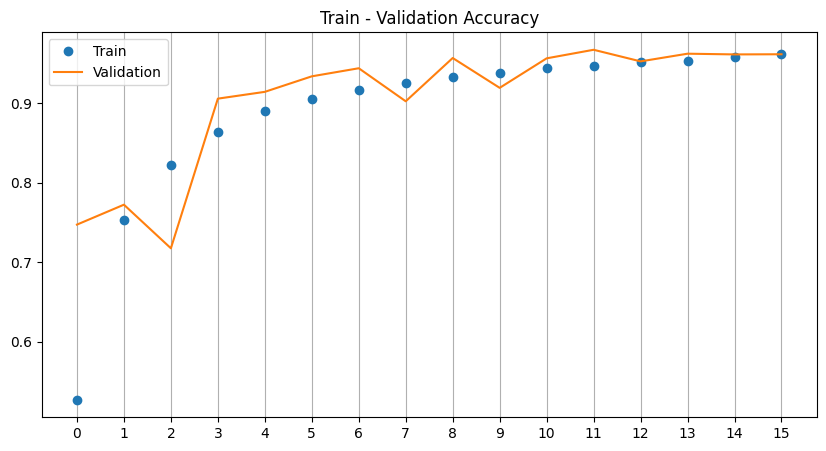

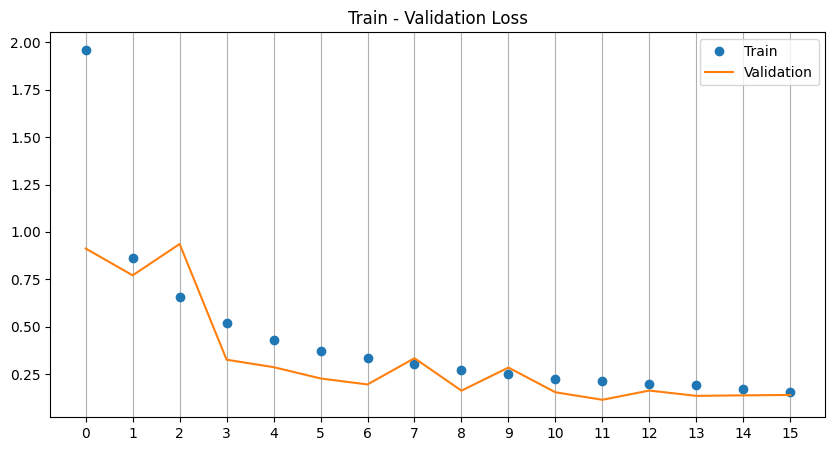

105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step


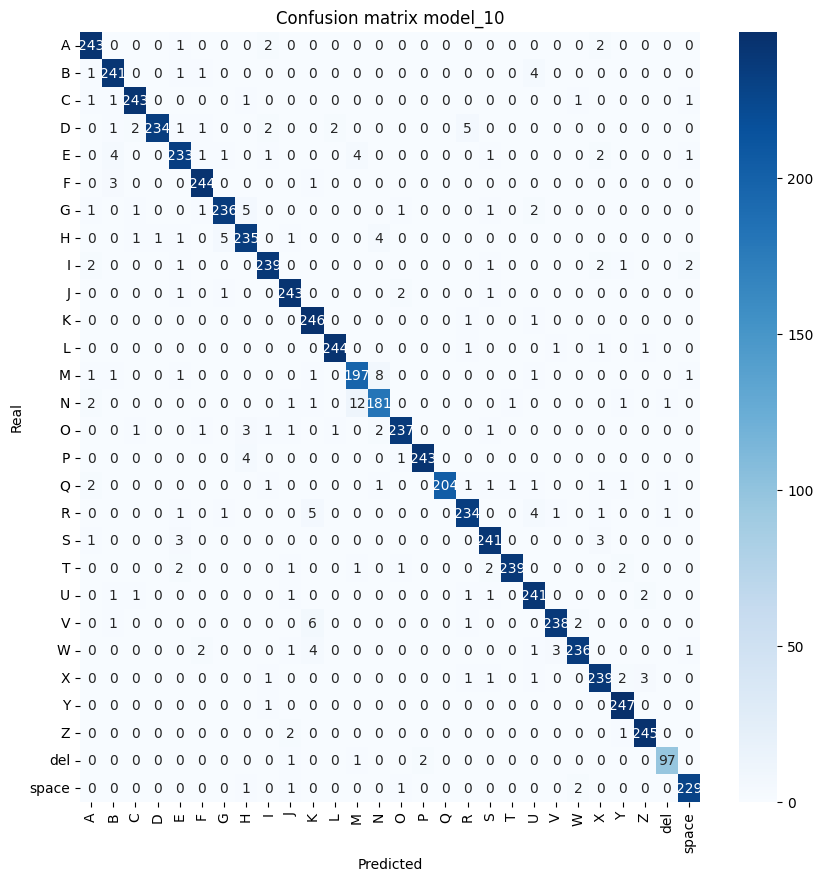

105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.9664 - loss: 0.1140
Test Accuracy: 0.9659
Max val Accuracy: 0.9670
Max train Accuracy: 0.9617


In [ ]:
evaluate_model('model_10',model_10, history_10)

In [ ]:
save_model('model_10',model_10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_11 = Sequential()

model_11.add(layers.Input(shape=(300,300,1)))

model_11.add(layers.Conv2D(8, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.4))

model_11.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.3))

model_11.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.4))

model_11.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))

model_11.add(layers.Dropout(0.4))

model_11.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))

model_11.add(layers.Dropout(0.5))

model_11.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.5))

model_11.add(layers.Flatten())
model_11.add(layers.Dense(512,activation='relu'))
model_11.add(layers.Dense(28,'softmax'))

model_11.summary()

model_11.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 6,
    restore_best_weights = True)
history_11 = model_11.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 30,
    validation_data = validation_generator,
    callbacks =[early_stop,checkpoint],
    validation_steps = len(validation_generator)
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 128)    │       147,58

 Total params: 3,477,100 (13.26 MB)

 Trainable params: 3,476,604 (13.26 MB)

 Non-trainable params: 496 (1.94 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4277 - loss: 2.1377
Epoch 1: val_loss improved from inf to 0.52738, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 183s 204ms/step - accuracy: 0.4280 - loss: 2.1366 - val_accuracy: 0.8418 - val_loss: 0.5274
Epoch 2/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8502 - loss: 0.5021
Epoch 2: val_loss improved from 0.52738 to 0.23261, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 115s 148ms/step - accuracy: 0.8502 - loss: 0.5021 - val_accuracy: 0.9302 - val_loss: 0.2326
Epoch 3/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9041 - loss: 0.3344
Epoch 3: val_loss did not improve from 0.23261
778/778 ━━━━━━━━━━━━━━━━━━━━ 131s 134ms/step - accuracy: 0.9041 - loss: 0.3344 - val_accuracy: 0.9278 - val_loss: 0.2510
Epoch 4/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9238 - loss: 0.2700
Epoch 4: val_loss improved from 0.23261 to 0.15814, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 106s 136ms/step - accuracy: 0.9239 - loss: 0.2699 - val_accuracy: 0.9552 - val_loss: 0.1581
Epoch 5/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9366 - loss: 0.2275
Epoch 5: val_loss improved from 0.15814 to 0.12586, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 141s 134ms/step - accuracy: 0.9366 - loss: 0.2274 - val_accuracy: 0.9652 - val_loss: 0.1259
Epoch 6/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9450 - loss: 0.2051
Epoch 6: val_loss did not improve from 0.12586
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.9450 - loss: 0.2051 - val_accuracy: 0.9531 - val_loss: 0.1649
Epoch 7/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9522 - loss: 0.1787
Epoch 7: val_loss improved from 0.12586 to 0.12381, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 112s 144ms/step - accuracy: 0.9522 - loss: 0.1787 - val_accuracy: 0.9669 - val_loss: 0.1238
Epoch 8/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9576 - loss: 0.1668
Epoch 8: val_loss did not improve from 0.12381
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 133ms/step - accuracy: 0.9576 - loss: 0.1668 - val_accuracy: 0.9416 - val_loss: 0.1992
Epoch 9/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9597 - loss: 0.1555
Epoch 9: val_loss improved from 0.12381 to 0.08418, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 106s 136ms/step - accuracy: 0.9597 - loss: 0.1555 - val_accuracy: 0.9751 - val_loss: 0.0842
Epoch 10/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9655 - loss: 0.1314
Epoch 10: val_loss did not improve from 0.08418
778/778 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - accuracy: 0.9655 - loss: 0.1314 - val_accuracy: 0.9771 - val_loss: 0.0901
Epoch 11/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9660 - loss: 0.1235
Epoch 11: val_loss did not improve from 0.08418
778/778 ━━━━━━━━━━━━━━━━━━━━ 148s 142ms/step - accuracy: 0.9660 - loss: 0.1235 - val_accuracy: 0.9775 - val_loss: 0.0911
Epoch 12/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9697 - loss: 0.1179
Epoch 12: val_loss did not improve from 0.08418
778/778 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - accuracy: 0.9697 - loss: 0.1179 - val_accuracy: 0.9784 - val_loss: 0.0845
Epoch 13/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9729 - loss: 0.1007
Epoch 13: val_lo

778/778 ━━━━━━━━━━━━━━━━━━━━ 109s 139ms/step - accuracy: 0.9729 - loss: 0.1007 - val_accuracy: 0.9816 - val_loss: 0.0748
Epoch 14/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9763 - loss: 0.0880
Epoch 14: val_loss improved from 0.07479 to 0.05896, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 106s 136ms/step - accuracy: 0.9763 - loss: 0.0880 - val_accuracy: 0.9853 - val_loss: 0.0590
Epoch 15/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9799 - loss: 0.0771
Epoch 15: val_loss did not improve from 0.05896
778/778 ━━━━━━━━━━━━━━━━━━━━ 108s 139ms/step - accuracy: 0.9799 - loss: 0.0771 - val_accuracy: 0.9857 - val_loss: 0.0660
Epoch 16/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9805 - loss: 0.0679
Epoch 16: val_loss did not improve from 0.05896
778/778 ━━━━━━━━━━━━━━━━━━━━ 138s 134ms/step - accuracy: 0.9805 - loss: 0.0679 - val_accuracy: 0.9822 - val_loss: 0.0690
Epoch 17/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9829 - loss: 0.0613
Epoch 17: val_loss improved from 0.05896 to 0.05289, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - accuracy: 0.9829 - loss: 0.0613 - val_accuracy: 0.9874 - val_loss: 0.0529
Epoch 18/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9848 - loss: 0.0518
Epoch 18: val_loss improved from 0.05289 to 0.05038, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.9848 - loss: 0.0518 - val_accuracy: 0.9883 - val_loss: 0.0504
Epoch 19/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9853 - loss: 0.0470
Epoch 19: val_loss did not improve from 0.05038
778/778 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - accuracy: 0.9853 - loss: 0.0470 - val_accuracy: 0.9845 - val_loss: 0.0611
Epoch 20/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9877 - loss: 0.0404
Epoch 20: val_loss improved from 0.05038 to 0.04995, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.9877 - loss: 0.0404 - val_accuracy: 0.9876 - val_loss: 0.0500
Epoch 21/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9880 - loss: 0.0399
Epoch 21: val_loss improved from 0.04995 to 0.04652, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 136ms/step - accuracy: 0.9880 - loss: 0.0399 - val_accuracy: 0.9880 - val_loss: 0.0465
Epoch 22/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9898 - loss: 0.0352
Epoch 22: val_loss did not improve from 0.04652
778/778 ━━━━━━━━━━━━━━━━━━━━ 104s 134ms/step - accuracy: 0.9898 - loss: 0.0352 - val_accuracy: 0.9875 - val_loss: 0.0582
Epoch 23/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9901 - loss: 0.0344
Epoch 23: val_loss did not improve from 0.04652
778/778 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - accuracy: 0.9900 - loss: 0.0344 - val_accuracy: 0.9893 - val_loss: 0.0489
Epoch 24/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9905 - loss: 0.0324
Epoch 24: val_loss improved from 0.04652 to 0.04533, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_2_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 134s 135ms/step - accuracy: 0.9905 - loss: 0.0324 - val_accuracy: 0.9903 - val_loss: 0.0453
Epoch 25/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9905 - loss: 0.0310
Epoch 25: val_loss did not improve from 0.04533
778/778 ━━━━━━━━━━━━━━━━━━━━ 142s 135ms/step - accuracy: 0.9905 - loss: 0.0310 - val_accuracy: 0.9878 - val_loss: 0.0515
Epoch 26/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9906 - loss: 0.0285
Epoch 26: val_loss did not improve from 0.04533
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.9906 - loss: 0.0285 - val_accuracy: 0.9877 - val_loss: 0.0617
Epoch 27/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9906 - loss: 0.0322
Epoch 27: val_loss did not improve from 0.04533
778/778 ━━━━━━━━━━━━━━━━━━━━ 152s 146ms/step - accuracy: 0.9906 - loss: 0.0322 - val_accuracy: 0.9689 - val_loss: 0.1384
Epoch 28/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9912 - loss: 0.0317
Epoch 28: val_lo

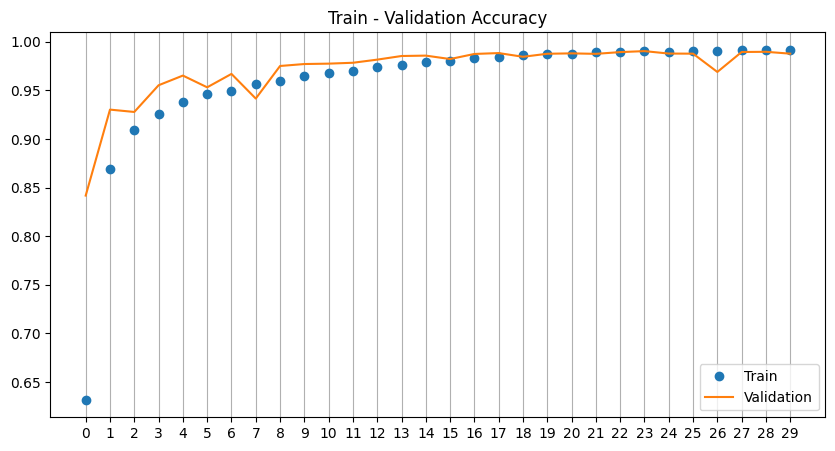

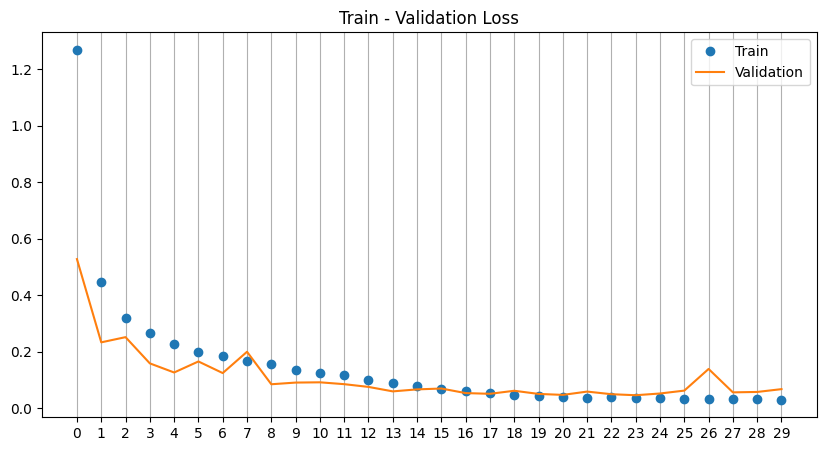

105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step


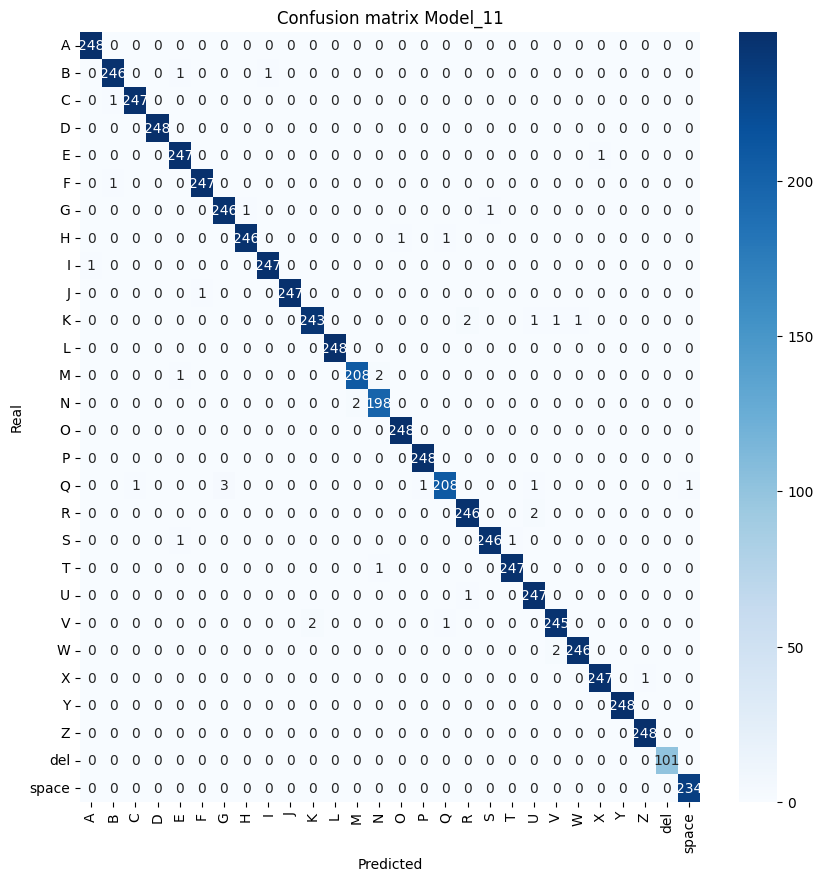

105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9948 - loss: 0.0231
Test Accuracy: 0.9928
Max val Accuracy: 0.9903
Max train Accuracy: 0.9917


In [ ]:
evaluate_model('Model_11',model_11,history_11)

In [ ]:
save_model('model_11',model_11)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_12 = Sequential()

model_12.add(layers.Input(shape=(300,300,1)))

model_12.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.2))

model_12.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.4))

model_12.add(layers.SeparableConv2D(32,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.4))

model_12.add(layers.SeparableConv2D(64,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.5))


model_12.add(layers.SeparableConv2D(128,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.4))


model_12.add(layers.SeparableConv2D(256,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.3))


model_12.add(layers.Flatten())
model_12.add(layers.Dense(512,activation='relu'))
model_12.add(layers.Dropout(0.4))
model_12.add(layers.Dense(28,'sigmoid'))

model_12.summary()

model_12.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_12_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_12_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience = 6,
    restore_best_weights = True)

history_12 = model_12.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks =[early_stop,checkpoint],
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 300, 300, 16)   │            41 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 150, 150, 16)   │           416 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 75, 75, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 37, 37, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 18, 18, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 9, 128)      │             

 Total params: 2,160,693 (8.24 MB)

 Trainable params: 2,159,669 (8.24 MB)

 Non-trainable params: 1,024 (4.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2729 - loss: 3.0427
Epoch 1: val_loss improved from inf to 3.75278, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 180s 201ms/step - accuracy: 0.2731 - loss: 3.0414 - val_accuracy: 0.3741 - val_loss: 3.7528
Epoch 2/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7018 - loss: 1.0149
Epoch 2: val_loss did not improve from 3.75278
778/778 ━━━━━━━━━━━━━━━━━━━━ 108s 139ms/step - accuracy: 0.7019 - loss: 1.0148 - val_accuracy: 0.2007 - val_loss: 12.7941
Epoch 3/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7864 - loss: 0.7287
Epoch 3: val_loss improved from 3.75278 to 0.92437, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 132s 127ms/step - accuracy: 0.7864 - loss: 0.7287 - val_accuracy: 0.7994 - val_loss: 0.9244
Epoch 4/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8250 - loss: 0.6040
Epoch 4: val_loss did not improve from 0.92437
778/778 ━━━━━━━━━━━━━━━━━━━━ 99s 127ms/step - accuracy: 0.8250 - loss: 0.6040 - val_accuracy: 0.7613 - val_loss: 1.2767
Epoch 5/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8491 - loss: 0.5281
Epoch 5: val_loss did not improve from 0.92437
778/778 ━━━━━━━━━━━━━━━━━━━━ 135s 118ms/step - accuracy: 0.8491 - loss: 0.5281 - val_accuracy: 0.6088 - val_loss: 2.5020
Epoch 6/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8597 - loss: 0.4846
Epoch 6: val_loss did not improve from 0.92437
778/778 ━━━━━━━━━━━━━━━━━━━━ 92s 118ms/step - accuracy: 0.8597 - loss: 0.4846 - val_accuracy: 0.7937 - val_loss: 1.1874
Epoch 7/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8775 - loss: 0.4313
Epoch 7: val_loss improve

778/778 ━━━━━━━━━━━━━━━━━━━━ 93s 120ms/step - accuracy: 0.8775 - loss: 0.4313 - val_accuracy: 0.9068 - val_loss: 0.3844
Epoch 8/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8872 - loss: 0.4061
Epoch 8: val_loss did not improve from 0.38435
778/778 ━━━━━━━━━━━━━━━━━━━━ 99s 127ms/step - accuracy: 0.8872 - loss: 0.4060 - val_accuracy: 0.3507 - val_loss: 4.1086
Epoch 9/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8976 - loss: 0.3651
Epoch 9: val_loss did not improve from 0.38435
778/778 ━━━━━━━━━━━━━━━━━━━━ 93s 119ms/step - accuracy: 0.8976 - loss: 0.3651 - val_accuracy: 0.4601 - val_loss: 2.6244
Epoch 10/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9032 - loss: 0.3466
Epoch 10: val_loss did not improve from 0.38435
778/778 ━━━━━━━━━━━━━━━━━━━━ 138s 114ms/step - accuracy: 0.9032 - loss: 0.3466 - val_accuracy: 0.8557 - val_loss: 0.5713
Epoch 11/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9079 - loss: 0.3235
Epoch 11: val_loss did no

778/778 ━━━━━━━━━━━━━━━━━━━━ 98s 126ms/step - accuracy: 0.9144 - loss: 0.3024 - val_accuracy: 0.9314 - val_loss: 0.3280
Epoch 13/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9223 - loss: 0.2779
Epoch 13: val_loss improved from 0.32803 to 0.27125, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 138s 121ms/step - accuracy: 0.9223 - loss: 0.2779 - val_accuracy: 0.9336 - val_loss: 0.2713
Epoch 14/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9265 - loss: 0.2571
Epoch 14: val_loss improved from 0.27125 to 0.26508, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 97s 125ms/step - accuracy: 0.9265 - loss: 0.2571 - val_accuracy: 0.9283 - val_loss: 0.2651
Epoch 15/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9350 - loss: 0.2295
Epoch 15: val_loss improved from 0.26508 to 0.21162, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 128ms/step - accuracy: 0.9350 - loss: 0.2295 - val_accuracy: 0.9474 - val_loss: 0.2116
Epoch 16/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9344 - loss: 0.2285
Epoch 16: val_loss improved from 0.21162 to 0.13808, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 133s 116ms/step - accuracy: 0.9344 - loss: 0.2285 - val_accuracy: 0.9594 - val_loss: 0.1381
Epoch 17/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9393 - loss: 0.2112
Epoch 17: val_loss did not improve from 0.13808
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.9393 - loss: 0.2112 - val_accuracy: 0.2660 - val_loss: 4.0354
Epoch 18/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9434 - loss: 0.1906
Epoch 18: val_loss did not improve from 0.13808
778/778 ━━━━━━━━━━━━━━━━━━━━ 132s 120ms/step - accuracy: 0.9434 - loss: 0.1907 - val_accuracy: 0.9619 - val_loss: 0.1494
Epoch 19/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9451 - loss: 0.1924
Epoch 19: val_loss did not improve from 0.13808
778/778 ━━━━━━━━━━━━━━━━━━━━ 98s 126ms/step - accuracy: 0.9451 - loss: 0.1924 - val_accuracy: 0.9500 - val_loss: 0.2133
Epoch 20/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9446 - loss: 0.1859
Epoch 20: val_los

778/778 ━━━━━━━━━━━━━━━━━━━━ 97s 125ms/step - accuracy: 0.9585 - loss: 0.1316 - val_accuracy: 0.9649 - val_loss: 0.1268
Epoch 28/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9593 - loss: 0.1278
Epoch 28: val_loss did not improve from 0.12679
778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 128ms/step - accuracy: 0.9593 - loss: 0.1278 - val_accuracy: 0.9468 - val_loss: 0.1891
Epoch 29/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9612 - loss: 0.1164
Epoch 29: val_loss improved from 0.12679 to 0.12543, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 93s 120ms/step - accuracy: 0.9612 - loss: 0.1164 - val_accuracy: 0.9661 - val_loss: 0.1254
Epoch 30/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9587 - loss: 0.1241
Epoch 30: val_loss did not improve from 0.12543
778/778 ━━━━━━━━━━━━━━━━━━━━ 143s 121ms/step - accuracy: 0.9587 - loss: 0.1241 - val_accuracy: 0.9563 - val_loss: 0.1527
Epoch 31/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9583 - loss: 0.1185
Epoch 31: val_loss did not improve from 0.12543
778/778 ━━━━━━━━━━━━━━━━━━━━ 142s 121ms/step - accuracy: 0.9583 - loss: 0.1185 - val_accuracy: 0.9596 - val_loss: 0.1443
Epoch 32/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9573 - loss: 0.1111
Epoch 32: val_loss improved from 0.12543 to 0.09711, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 93s 120ms/step - accuracy: 0.9573 - loss: 0.1111 - val_accuracy: 0.9734 - val_loss: 0.0971
Epoch 33/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9603 - loss: 0.1088
Epoch 33: val_loss did not improve from 0.09711
778/778 ━━━━━━━━━━━━━━━━━━━━ 94s 121ms/step - accuracy: 0.9603 - loss: 0.1088 - val_accuracy: 0.7657 - val_loss: 0.8269
Epoch 34/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9596 - loss: 0.1022
Epoch 34: val_loss did not improve from 0.09711
778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 124ms/step - accuracy: 0.9596 - loss: 0.1022 - val_accuracy: 0.4595 - val_loss: 2.8057
Epoch 35/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9564 - loss: 0.1026
Epoch 35: val_loss did not improve from 0.09711
778/778 ━━━━━━━━━━━━━━━━━━━━ 137s 118ms/step - accuracy: 0.9564 - loss: 0.1026 - val_accuracy: 0.7522 - val_loss: 0.9192
Epoch 36/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9592 - loss: 0.1088
Epoch 36: val_loss

778/778 ━━━━━━━━━━━━━━━━━━━━ 129s 120ms/step - accuracy: 0.9546 - loss: 0.1000 - val_accuracy: 0.9715 - val_loss: 0.0919
Epoch 38/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9512 - loss: 0.0980
Epoch 38: val_loss did not improve from 0.09188
778/778 ━━━━━━━━━━━━━━━━━━━━ 91s 117ms/step - accuracy: 0.9512 - loss: 0.0980 - val_accuracy: 0.9534 - val_loss: 0.1592
Taks done in 1:15:36.669607


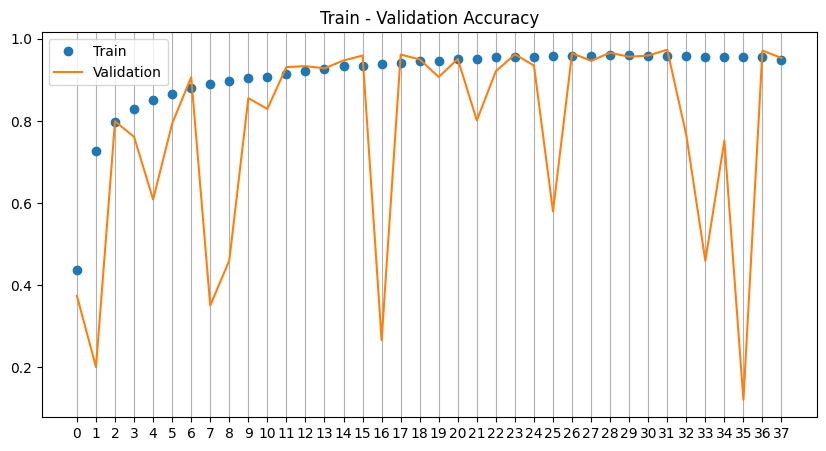

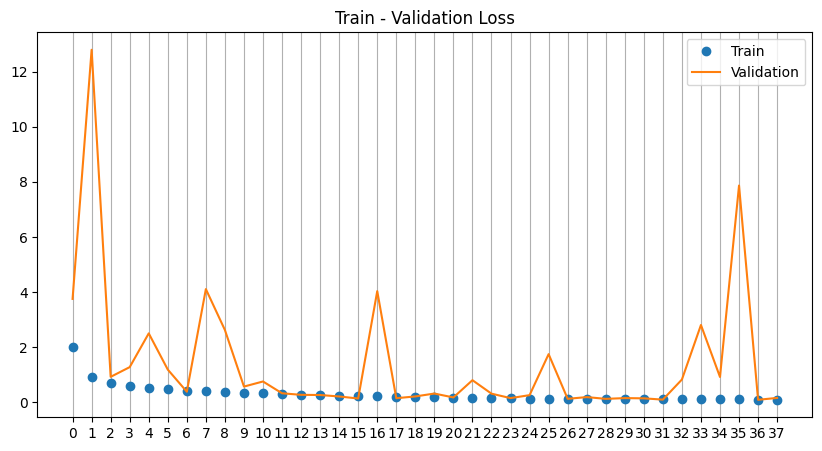

105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step


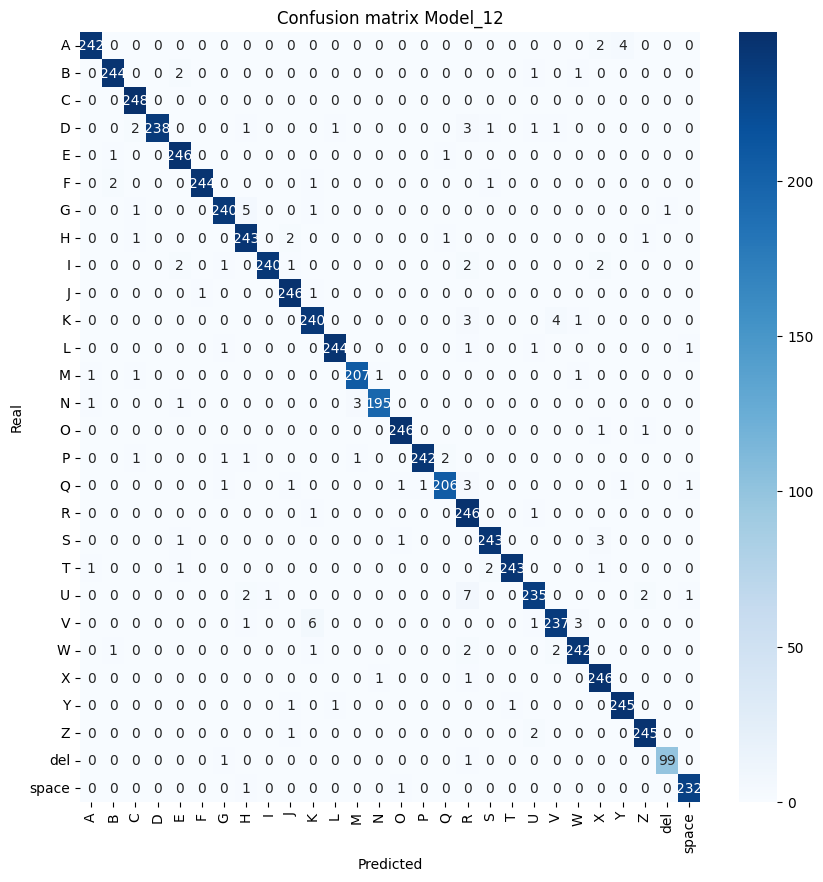

105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9803 - loss: 0.0777
Test Accuracy: 0.9800
Max val Accuracy: 0.9734
Max train Accuracy: 0.9610


In [ ]:
evaluate_model('Model_12',model_12,history_12)

In [ ]:
save_model('model_12',model_12)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_7 = Sequential()

model_7.add(layers.Input(shape=(300,300,1)))

model_7.add(layers.Conv2D(8, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Dropout(0.3))

model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Dropout(0.3))

model_7.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))

model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Flatten())
model_7.add(layers.Dense(512,activation='relu'))
model_7.add(layers.Dense(28,'sigmoid'))

model_7.summary()

model_7.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_7_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience = 6,
    restore_best_weights = True)
history_7 = model_7.fit(
    train_generator,
    # steps_per_epoch = 250,
    epochs = 50,
    validation_data = validation_generator,
    callbacks =[early_stop,checkpoint],
    validation_steps = 100
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 300, 300, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 300, 300, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,887,020 (11.01 MB)

 Trainable params: 2,886,524 (11.01 MB)

 Non-trainable params: 496 (1.94 KB)

Epoch 1/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5382 - loss: 2.2572
Epoch 1: val_accuracy improved from -inf to 0.90516, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 126s 141ms/step - accuracy: 0.5385 - loss: 2.2555 - val_accuracy: 0.9052 - val_loss: 0.3060
Epoch 2/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9415 - loss: 0.2045
Epoch 2: val_accuracy improved from 0.90516 to 0.93094, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 141s 155ms/step - accuracy: 0.9415 - loss: 0.2045 - val_accuracy: 0.9309 - val_loss: 0.2539
Epoch 3/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9635 - loss: 0.1277
Epoch 3: val_accuracy improved from 0.93094 to 0.96828, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 143s 156ms/step - accuracy: 0.9635 - loss: 0.1277 - val_accuracy: 0.9683 - val_loss: 0.1252
Epoch 4/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9731 - loss: 0.0972
Epoch 4: val_accuracy did not improve from 0.96828
778/778 ━━━━━━━━━━━━━━━━━━━━ 141s 181ms/step - accuracy: 0.9731 - loss: 0.0972 - val_accuracy: 0.9634 - val_loss: 0.1580
Epoch 5/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9791 - loss: 0.0737
Epoch 5: val_accuracy improved from 0.96828 to 0.97609, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 97s 123ms/step - accuracy: 0.9791 - loss: 0.0737 - val_accuracy: 0.9761 - val_loss: 0.1154
Epoch 6/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9837 - loss: 0.0627
Epoch 6: val_accuracy did not improve from 0.97609
778/778 ━━━━━━━━━━━━━━━━━━━━ 96s 123ms/step - accuracy: 0.9837 - loss: 0.0627 - val_accuracy: 0.9453 - val_loss: 0.3046
Epoch 7/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9849 - loss: 0.0634
Epoch 7: val_accuracy did not improve from 0.97609
778/778 ━━━━━━━━━━━━━━━━━━━━ 141s 123ms/step - accuracy: 0.9849 - loss: 0.0634 - val_accuracy: 0.9720 - val_loss: 0.1416
Epoch 8/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9888 - loss: 0.0471
Epoch 8: val_accuracy did not improve from 0.97609
778/778 ━━━━━━━━━━━━━━━━━━━━ 201s 199ms/step - accuracy: 0.9888 - loss: 0.0471 - val_accuracy: 0.9666 - val_loss: 0.1785
Epoch 9/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9886 - loss: 0.0484
Epoch 9: val_

778/778 ━━━━━━━━━━━━━━━━━━━━ 143s 184ms/step - accuracy: 0.9904 - loss: 0.0418 - val_accuracy: 0.9798 - val_loss: 0.1343
Epoch 11/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9920 - loss: 0.0351
Epoch 11: val_accuracy did not improve from 0.97984
778/778 ━━━━━━━━━━━━━━━━━━━━ 201s 182ms/step - accuracy: 0.9920 - loss: 0.0351 - val_accuracy: 0.9769 - val_loss: 0.1223
Epoch 12/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9928 - loss: 0.0303
Epoch 12: val_accuracy improved from 0.97984 to 0.98453, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_3_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 143s 184ms/step - accuracy: 0.9928 - loss: 0.0303 - val_accuracy: 0.9845 - val_loss: 0.0988
Epoch 13/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9938 - loss: 0.0262
Epoch 13: val_accuracy did not improve from 0.98453
778/778 ━━━━━━━━━━━━━━━━━━━━ 141s 181ms/step - accuracy: 0.9938 - loss: 0.0262 - val_accuracy: 0.9831 - val_loss: 0.1230
Epoch 14/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9940 - loss: 0.0253
Epoch 14: val_accuracy did not improve from 0.98453
778/778 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step - accuracy: 0.9940 - loss: 0.0253 - val_accuracy: 0.9842 - val_loss: 0.1178
Epoch 15/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9923 - loss: 0.0218
Epoch 15: val_accuracy did not improve from 0.98453
778/778 ━━━━━━━━━━━━━━━━━━━━ 202s 199ms/step - accuracy: 0.9923 - loss: 0.0218 - val_accuracy: 0.9809 - val_loss: 0.1244
Epoch 16/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9897 - loss: 0.0219
Epoch

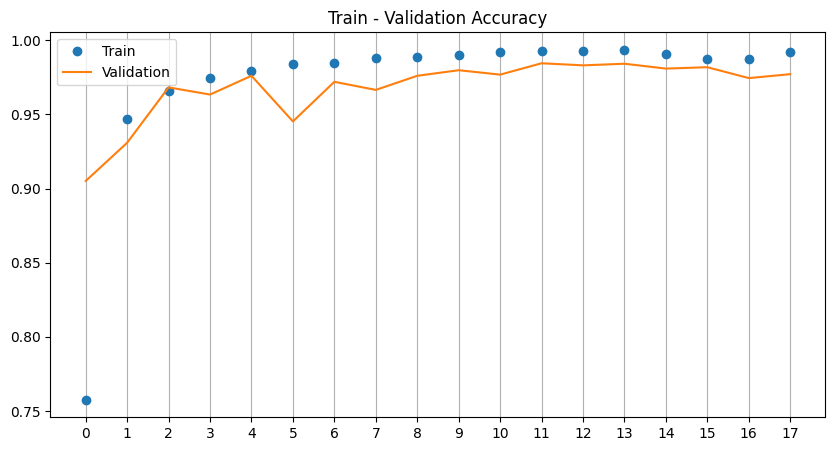

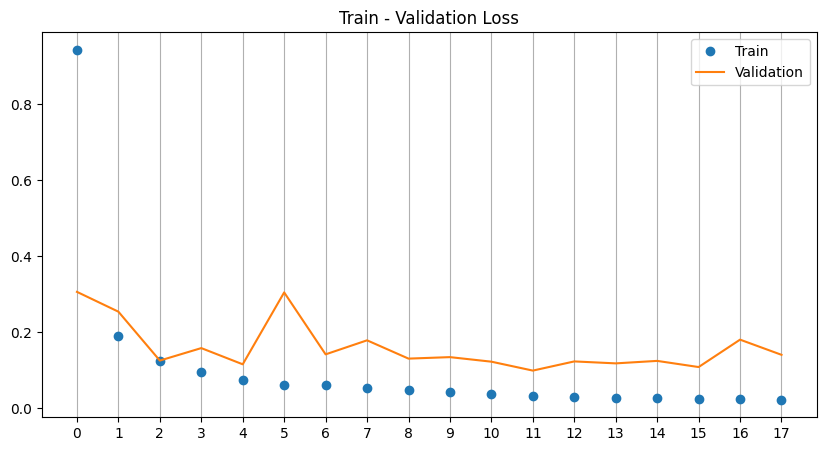

105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step


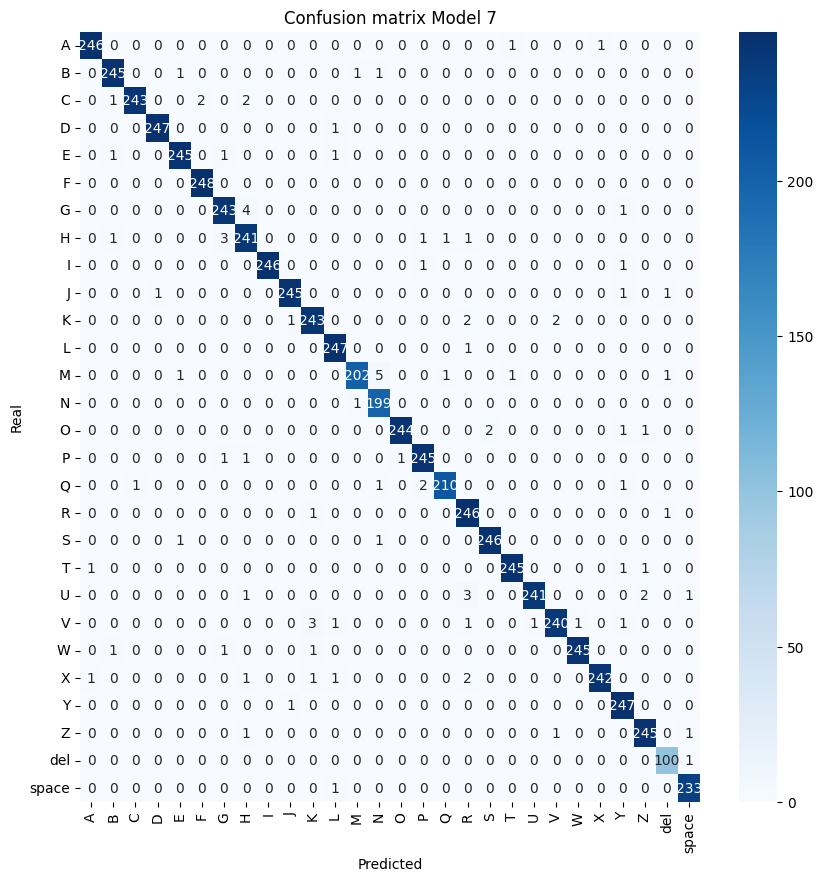

105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9862 - loss: 0.0704
Test Accuracy: 0.9854
Max val Accuracy: 0.9845
Max train Accuracy: 0.9936


In [ ]:
evaluate_model('Model 7',model_7,history_7)

In [ ]:
save_model('model_7',model_7)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>